In [1]:
import numpy as np
from numpy import log, pi, exp

from scipy.stats import norm, gamma
from scipy.special import loggamma
from scipy.special import gamma as scigamma

from seaborn import kdeplot

import matplotlib.colors as colors
from matplotlib import cm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pymc3 as pm
from pymc3.stats import summary

## Before submitting
1. Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

2. Make sure that no assertions fail or exceptions occur, otherwise points will be subtracted.

4. Please submit only the `*.ipynb` file.

5. Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE". Edit only between `YOUR CODE HERE` and `END YOUR CODE`.

6. Make sure to use Python 3, not Python 2.

Fill your group name and collaborators below:

In [2]:
GROUPNAME = "42"
COLLABORATORS = "Duc Viet Nguyen, Viktor Glombik"

$\newcommand{\lrg}{\large{}}$
$\newcommand{\ltxt}[1]{\lrg\text{#1}}$
$\newcommand{\nfr}[2]{ {}^{#1}/_{#2} }$

### Exercise 1.1: Student's T distribution (5 pts)

* Implement robust studentsT pdf function
* Ensure that the $\nu$ and $\sigma$ parameters are positive

### Student's T distribution PDF
<hr>
$$\lrg{
p(x | \mu, \sigma, \nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\Gamma(\nfr{\nu}{2})} \Big({\pi\nu\sigma^2} \Big)^{-\frac{1}{2}} \bigg( 1 + \frac{(x - \mu)^2}{\nu\sigma^2}\bigg)^{-\frac{\nu +1}{2}}
}$$

In [3]:
def studentsT(x, mu, sigma, nu):
    assert nu > 0 and sigma > 0
    log_student = loggamma((nu + 1)/2) - loggamma(nu/2) - log(pi * nu * sigma**2)/2 - (nu + 1)/2 * log(1 + (x - mu)**2/(nu * sigma**2))
    return exp(log_student)

### Exercise 1.2: Student's T distribution (5 pts)

* Plot Stundent's T pdf for diffrent gaussianity values $\nu$

Your plot should look like:

<img src='stT.png'>


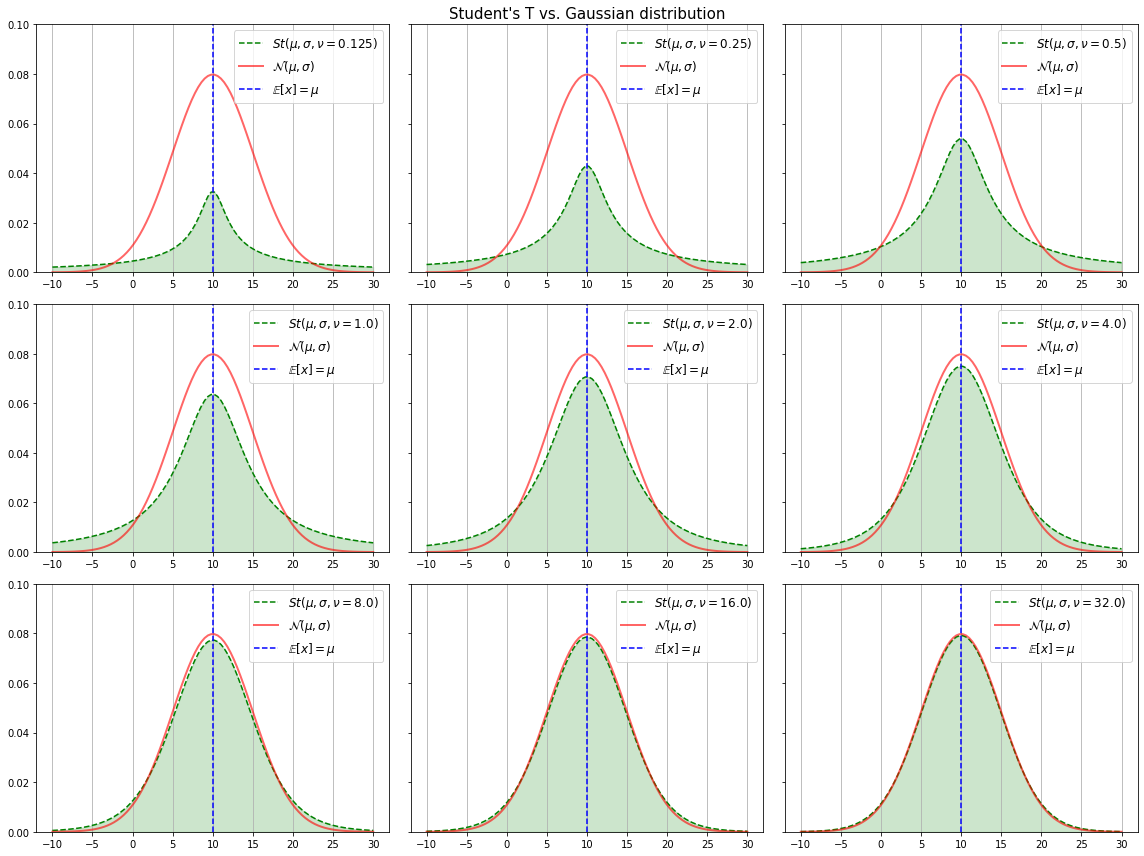

In [4]:
x = np.linspace(-10,30,100)

mu = 10
sigma = 5

twos = np.array(9*[2.])
nus = np.power(twos,np.arange(-3,6))                      # [1/8, 1/4, 1/2, 1, 2, 4, 8, 16,32]

f,axis = plt.subplots(3,3,figsize=(16,12), sharey=True)

n=0
for i in range(3):
    for j in range(3):
        ax = axis[i,j]
        nu = nus[n]
        
        ax.plot(x,studentsT(x,mu,sigma, nu), ls = '--', color = 'g', label = '$St(\mu, \sigma,\\nu={})$'.format(nu))
        ax.fill_between(x, 0, studentsT(x,mu,sigma, nu), color='g', alpha=0.2)
        ax.plot(x, norm.pdf(x,loc=mu,scale = sigma),'r', lw = 2, alpha=0.6, label='$\mathcal{N}(\mu,\sigma)$')
        ax.axvline(10, ls = '--', color = 'b', label = '$\mathbb{E}[x]=\mu$')
        
        
        n+=1
        ax.grid(axis='x')
        ax.legend(loc=1, fontsize=12)
        ax.set_ylim(0,0.1)
axis[0,1].set_title('Student\'s T vs. Gaussian distribution', fontsize=15)
plt.tight_layout()

In [5]:
def get_colors(X, min_val=None, max_val=None):
    if min_val is None:
        min_val = X.min()
    if max_val is None:
        max_val = X.max()
    cNorm  = colors.Normalize(vmin=min_val, vmax=max_val)
    cmap =  cm.ScalarMappable(norm=cNorm, cmap=cm.rainbow)
    return cmap.to_rgba(X)

### Exercise 2.1: Gamma and Normal samples (5 pts)

* Draw $N=10000$ samples from Gamma distribution for the given $a$ and $b$ values


* Compute pdf value for each of the sampled points 


* Create 1-dim data representation plot with color as pdf values and rainbow colormap


* Depict first moment of the Gamma distribution

Your plot should look like:

<img src='gam.png' width=500>

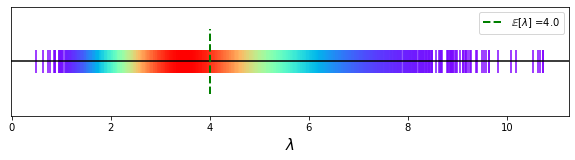

In [6]:
N = 10000
a = 8
b = 2
E_lambd = a/b
scale = 1./b

lambdas = np.random.gamma(a,scale,N) # samples
pdfs = gamma.pdf(lambdas,a,loc=0,scale = scale)

col = get_colors(pdfs)
plt.figure(figsize=(10,2))
plt.scatter(lambdas, np.zeros(len(pdfs)), marker='|',  c=col,s=500)
plt.axhline(0,color='k')
plt.axvline(E_lambd,ls='--', color='g' ,ymin=0.2, ymax=0.8, linewidth=2, label='$\\mathbb{E}[\\lambda]$ ='+f'{a/b:.2}')
plt.xlabel('$\\lambda$', fontsize=15)
plt.yticks([])
_=plt.legend()

* Draw $N=10000$ samples from Normal distribution for the given $\sigma$ value.


* Compute pdf value for each of the sampled points 


* Create 1-dim data representation plot with color as pdf values and rainbow colormap


* Depict first moment of the Normal distribution

Your plot should look like:

<img src='normal.png' width=500>

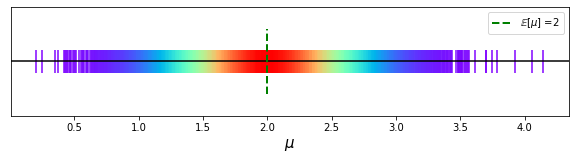

In [7]:
m_0 = 2
sigma =1./E_lambd**0.5

S1 = np.random.normal(m_0,sigma,N) # samples
pdfs = norm.pdf(S1,loc = m_0, scale = sigma)

col = get_colors(pdfs)
plt.figure(figsize=(10,2))
plt.scatter(S1, np.zeros(len(pdfs)), marker='|',  c=col,s=500)
plt.axhline(0,color='k')
plt.axvline(m_0,ls='--', color='g' ,ymin=0.2, ymax=0.8, linewidth=2, label='$\\mathbb{E}[\\mu]$ ='+str(m_0))
plt.xlabel('$\\mu$', fontsize=15)
plt.yticks([])
_=plt.legend()

### Exercise 2.2: Normal-gamma PDF (5 pts)

* Implement Normal-gamma distribution as a product of two pdf functions (norm and gamma) from scipy.stats package

### Normal-gamma distribution

$$\lrg{
p(\mu,\lambda| m, \beta, a, b ) = \text{NormGam}(\mu,\lambda | m,\beta,a,b) = \mathcal{N}(\mu | m, (\beta\lambda)^{-1}) \text{Gamma}(\lambda| a,b)
}$$

$$\boxed{\lrg{\text{NormGam}(\mu,\lambda | m,\beta,a,b)=
\left(\frac{\beta\lambda}{2\pi}\right)^{\frac{1}{2}}\exp\left(-\frac{\beta\lambda\cdot(\mu - m)^2}{2}\right) \cdot \frac{b^a}{\Gamma(a)}\lambda^{(a - 1)}\exp{(-b\lambda)}
}}$$

In [8]:
def normal_gamma(mu, lambd, m_0=0, beta=1, a=1, b=1):
    return norm.pdf(mu,loc = m_0, scale = 1/(beta * lambd)) * gamma.pdf(lambd,a,loc=a/b,scale = 1/b)

def normal_gamma2(mu, lambd, m_0=0, beta=1, a=1, b=1):
    return ((beta * lambd) / (2 * pi))**(1/2) * exp(- (beta * lambd) * (mu - m_0)**2 /2) * b**a / scigamma(a) * lambd**(a-1) * exp(- b * lambd)

## why dont the two agree???
#print(norm.pdf(1,1,1), (1 / (2 * pi))**(1/2) * exp(- (1)**2 /2))
#print(normal_gamma(1,1,2,0.5,8,2),normal_gamma2(1,1,2,0.5,8,2))

### Exercise 2.3: Normal-gamma density plot (10 pts)

* Create a plot of the Normal-gamma density for given $\beta$ values within the given range

* Depict different density regions as a color bar.

Your plot should look like:

<img src='col.png' width=1000>

In [9]:
mus = np.linspace(-6, 10, 100)
lambdas = np.linspace(1e-2, 8, 100)
M, L = np.meshgrid(mus, lambdas)

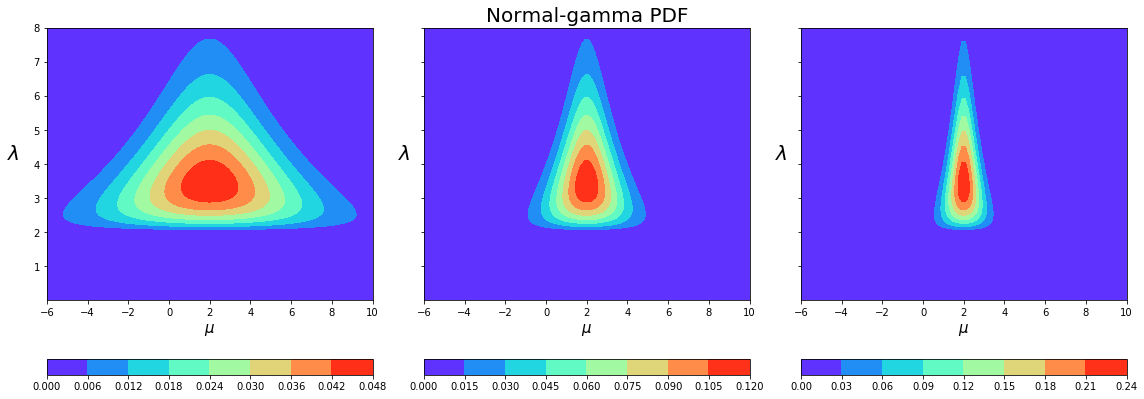

In [10]:
betas = [0.1, .25, .5]
f,axis = plt.subplots(1, len(betas), figsize=(16,6), sharey=True, sharex=False)

for i in range(len(betas)):
    ax = axis[i]
    
    Z = normal_gamma(M,L,m_0=2,beta = betas[i],a=2,b=1)
    cp = ax.contourf(M, L, Z, cmap = cm.rainbow)
    plt.colorbar(cp,ax = ax,orientation='horizontal', norm = True)
    
    
    ax.set_xlabel('$\\mu$',fontsize=15)
    ax.set_ylabel('$\\lambda$',fontsize=20, rotation=0, labelpad=20)


axis[1].set_title('Normal-gamma PDF', fontsize=20)
plt.tight_layout()

### Exercise 2.4: Normal to Normal-gamma conjugacy ( 10 pts)


* Use random state $= 42$ for all random sampling functions in this exercise


* Draw lambda value from Gamma distribution for given $a$ and $b$ values


* Generate $N=25$ toy data points drown from Normal distribution with given mean $\mu = m_0$ and scale value $\large{\sigma = \frac{1}{\sqrt\lambda} }$


In [11]:
# Toy data
N = 25

m_0 = 2
a_true = 4
b_true = 2
scale = 1/b_true

np.random.seed(42)

lambd = gamma.rvs(a_true,loc = a_true/b_true, scale = scale,size = 1)[0]
S = norm.rvs(loc = m_0, scale = lambd**(-1/2), size = N)



# YOUR CODE HERE

print(f'True lambda: {lambd:.2f}')
print(f'True sigma: {sigma:.2f}')
print("True mean: ", m_0)

True lambda: 4.35
True sigma: 0.50
True mean:  2



* Depict your samples data as 1-dim plot together with the histogram density plot


* Compute and depict empirical mean of your data

<img src='toy.png' width=800>

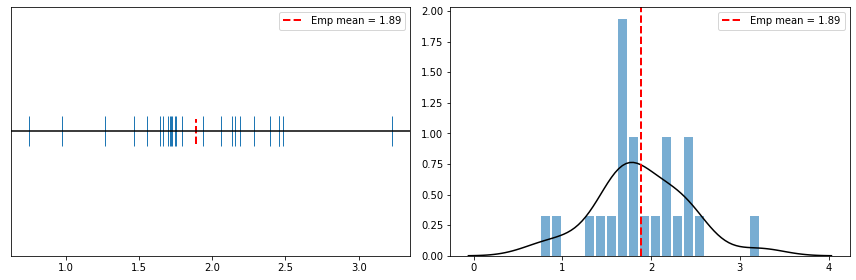

In [12]:
f,axis = plt.subplots(1, 2, figsize=(12,4), sharey=False, sharex=False)

ax = axis[0]

ax.plot(S, np.zeros(N), '|', markersize=30, color='C0')
ax.axvline(S.mean(),ls='--', color='r' ,ymin=0.45, ymax=0.55, linewidth=2, label='Emp mean = {}'.format(round(S.mean(),2)))
ax.axhline(0,ls = '-', color = 'black')

ax.legend()
ax.set_yticks([])

ax = axis[1]

ax.hist(S,bins=20, rwidth=0.8, alpha=0.6, density=True)
_=kdeplot(S, color='black')
ax.axvline(S.mean(),ls='--', color='r', linewidth=2, label='Emp mean = {}'.format(round(S.mean(),2)))

ax.legend(loc=1)
plt.tight_layout()

### Exercise 2.5: Normal-gamma posterior (5 pts)

<hr>


* Implement Normal-gamma posterior function as a function of $\mu$ and $\lambda$ for given data $X$ and hyperparameters $m_0, \beta_0, a_0, b_0$



* Your function should return computed pdf values, first moment of $\mu$ and $\lambda$



$$\lrg{
p(\mu,\lambda | X, m_0, \beta_0, a_0, b_0) = \text{NormGam}(\mu, \lambda | m, \beta, a, b ),\ \text{where}
}$$

$$\boxed{\lrg{
\beta =  \beta_0 + N, \quad m = \frac{N\overline{X} + \beta_0m_0}{\beta}, \quad a = a_0 + \frac{N}{2},\quad b = b_0 + \frac{1}{2}\bigg( \sum_{n=1}^N (X_n - \overline{X})^2 + \frac{N\beta_0(\overline{X} - m_0)^2}{\beta}\bigg),\\  \quad \overline{X} = \frac{1}{N}\sum_{n=1}^N X_n
}}$$

$$\lrg{
\mathbb{E}[\mu] = m,\quad \mathbb{E}[\lambda] = \frac{a}{b}
}$$ 

In [13]:
def posterior(mu, lambd, X, m_0, beta_0, a_0, b_0):
    N = len(X)
    beta = beta_0 + N
    a = a_0 + N/2
    b = b_0 + 0.5*(np.sum((X - np.mean(X))**2) + (N* beta_0*(np.mean(X) - m_0)**2) / beta)
    
    pdfs = normal_gamma2(mu, lambd, m_0, beta, a, b)
    Em = (N * np.mean(X) + beta_0 * m_0) / beta
    E1 = a / b
    
    return pdfs, Em, E1

### Exercise 2.5: Normal-gamma posterior density (5 pts)


* Depict Normal-gamma posterior density region for the given region as a filled countour plot


* Depict first moments of $\mu$ and $\lambda$ from your posterior.

Your plot should look like:

<img src='post.png' width=500>

In [14]:
mus = np.linspace(1.825, 1.98, 100)
lambdas = np.linspace(1, 4.5, 100)
M, L = np.meshgrid(mus, lambdas)

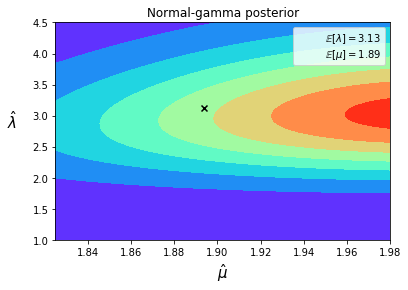

In [15]:
beta_0 = 1
a_0 = 4
b_0 = 2
X = S
xm = X.mean()

fig,ax=plt.subplots(1,1)


Z= posterior(M,L,X, m_0, beta_0, a_0, b_0)[0]
a, Em, El = posterior(M[0],L[0],X, m_0, beta_0, a_0, b_0)
cp = ax.contourf(M, L, Z, cmap = cm.rainbow)

ax.set_ylabel('$\\hat\lambda$', rotation=0, fontsize=15, labelpad=20)
ax.set_xlabel('$\\hat\mu$',fontsize=15)
ax.set_title('Normal-gamma posterior')
ax.scatter(Em,El,marker='x', color='k')
ax.scatter(Em,El, alpha=0, label='$\\mathbb{E}[\lambda]=$'+f'{El:.2f}'+'\n'+'$\\mathbb{E}[\mu] = $'+f'{Em:.2f}')
_=ax.legend()

In [ ]:
print(f'True lambda:\t{lambd:.2f}\t'+f'| Est lambda:\t{El:.2f}')
print(f'True sigma:\t{sigma:.2f}\t'+f'| Est sigma:\t{1/El**0.5:.2f}')
print(f"True mean:\t{m_0}\t" +f'| Est mean:\t{Em:.2f}')

### Exercise 3.1: Normal to Normal-gamma by sampling (10 pts)


* Define a probabilistic model using pyMC3 package


* Use _Gamma_ function for lambda parameter with $a = b = 1$


* Use _Deterministic_ function to compute scale $\sigma$


* Use _Normal_ function for mean $\mu$ with $mu = 0$ and $sd = 10$


* Use _Normal_ function to define your likelihood 

In [19]:
gauss_gam = pm.Model()

with gauss_gam:
    lambd = pm.Gamma('lambd', alpha=1, beta=1)
    sigma = pm.Deterministic('sigma', 1/np.sqrt(lambd))
    m = pm.Normal('m', mu=0, sd=10)
    likelihood = pm.Normal('likelihood', mu = m, sd = sigma,observed=X)

* Draw 10000 posterior samples from your prob model with 1000 tune steps and 4 chains 

In [20]:
with gauss_gam:
    continous = pm.NUTS(vars=[lambd, sigma, m])    
    trace = pm.sample(draws=10000,chains=4, tune=1000, step=[continous])

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m, lambd]
Sampling 4 chains, 0 divergences:  50%|█████     | 22000/44000 [00:12<00:12, 1755.23draws/s]


### Exercise 3.2: Analysis of the posterior samples (5 pts)

* Depict your collected trace with _traceplot_ function

Your plot should look like:

<img src='trace.png' width=800>

/usr/local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


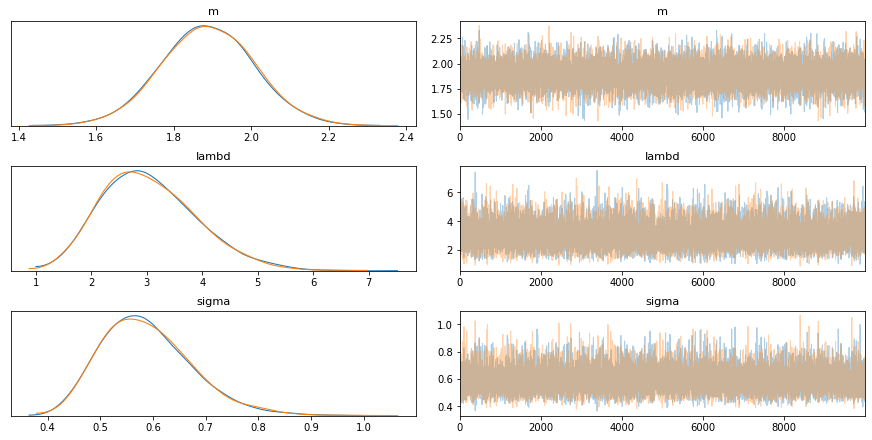

In [21]:
_=pm.traceplot(trace, var_names=['m', 'lambd', 'sigma']) # Specify which variables to plot

* Show your trace summary

<img src='summary.png' width=500>

In [22]:
pm.summary(trace,var_names=['m','lambd','sigma'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m,1.889,0.120,1.668,2.120,0.001,0.001,15163.0,15163.0,15221.0,12299.0,1.0
lambd,3.058,0.857,1.526,4.654,0.007,0.005,14458.0,13876.0,14607.0,12583.0,1.0
sigma,0.589,0.086,0.441,0.750,0.001,0.001,14477.0,14193.0,14607.0,12531.0,1.0


* Show your posterior plot using _plot_posterior_ function

<img src='p_post.png' width=800>

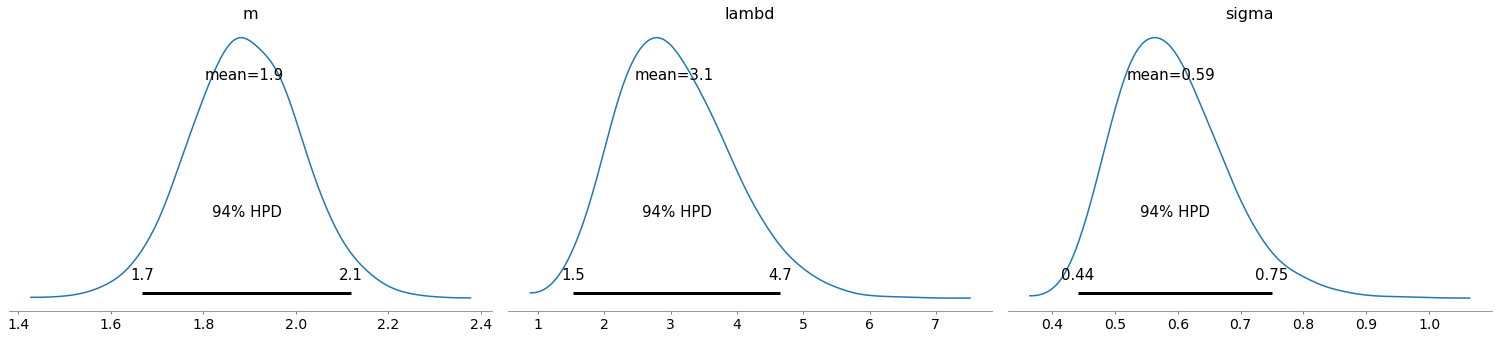

In [23]:
_=pm.plot_posterior(trace)

### Exercise 3.3: Posterior predictive approximation (5 pts)

* Collect 5000 posterior samples by using _sample_posterior_predictive_ function

In [24]:
with gauss_gam:
    ppc = pm.sample_posterior_predictive(trace, model=gauss_gam, samples=5000)

/usr/local/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 5000/5000 [00:04<00:00, 1127.04it/s]


* Create approx pedictive function as histogram density plot with kde function

Your plot should look like:

<img src='pred.png' width=400>

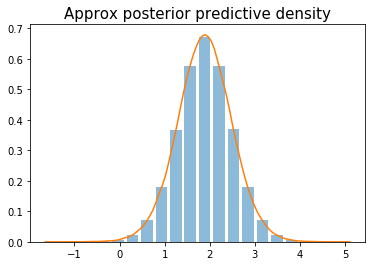

In [25]:
k = ppc['likelihood']
plt.hist(k.flatten(), bins=20, rwidth=0.8, density=True, alpha=0.5)
kdeplot(k.flatten())

_=plt.title('Approx posterior predictive density', fontsize=15)

* Depict posterior samples for $\mu$ and $\lambda$ as a scatter plot.

Your plot should look like:

<img src='smpl.png' width=400>

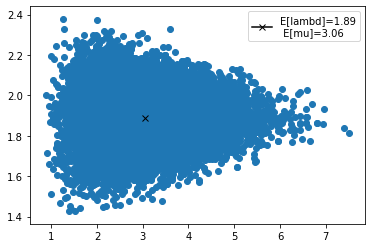

In [26]:
m_mean = np.mean(trace['m'])
l_mean = np.mean(trace['lambd'])

plt.scatter(trace['lambd'], trace['m'])
plt.plot(l_mean, m_mean, marker="x", c="black", label="E[lambd]={}\n E[mu]={}".format(round(m_mean,2), round(l_mean,2)))
plt.legend()
_=plt.show

### Exercise 3.4: Posterior density estimation (5 pts)


* Estimate posterior density by using _gaussian_kde_ function from scipy package.


* Depict your Normal-gamma posterior approximation as filled contour plot for the given range.

Your plot should look like:

<img src='kde.png' width=600>


In [27]:
from scipy.stats import gaussian_kde

mus = np.linspace(1.825, 1.98, 100)
lambdas = np.linspace(1, 4.5, 100)
M, L = np.meshgrid(mus, lambdas)

from scipy.stats import gaussian_kde

mus = np.linspace(1.825, 1.98, 100)
lambdas = np.linspace(1, 4.5, 100)
M, L = np.meshgrid(mus, lambdas)


values = np.vstack([trace['m'], trace['lambd']])
kernel = gaussian_kde(values)

# Regular grid to evaluate kde upon
x_flat = np.r_[values[:,0].min():values[:,0].max():100j]
y_flat = np.r_[values[:,1].min():values[:,1].max():100j]
x,y = np.meshgrid(x_flat,y_flat)
grid_coords = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)

z = kernel(grid_coords.T)
z = z.reshape(100,100)


positions = np.vstack([M.ravel(), L.ravel()])
# YOUR CODE HERE
Z = np.reshape(kernel(positions), (100,100))


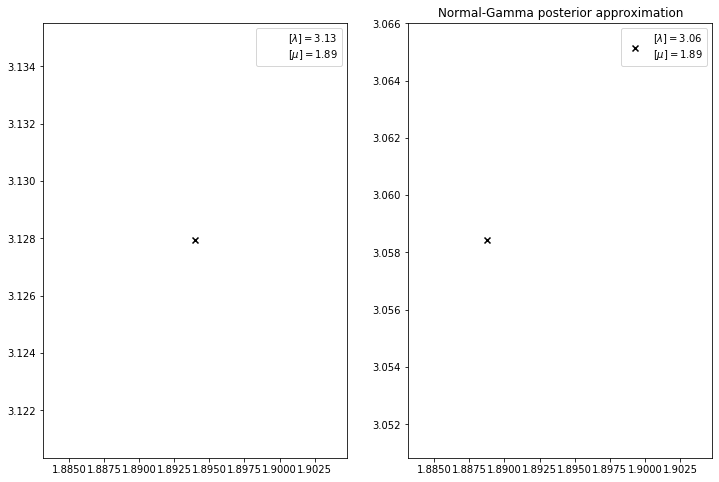

In [28]:
fig,axis=plt.subplots(1,2, figsize=(12,8), sharex=True)

ax = axis[0]

# YOUR CODE HERE

ax.scatter(Em,El,marker='x', color='k')
ax.scatter(Em,El, alpha=0, label='$\\mathbb{E}[\lambda]=$'+f'{El:.2f}'+'\n'+'$\\mathbb{E}[\mu] = $'+f'{Em:.2f}')
ax.legend()

ax = axis[1]

# YOUR CODE HERE

ax.set_title('Normal-Gamma posterior approximation')
ax.scatter(m_mean,l_mean, color='k', marker='x', label='$\\mathbb{E}[\lambda]=$'+f'{l_mean:.2f}'+'\n'+'$\\mathbb{E}[\mu] = $'+f'{m_mean:.2f}')
_=ax.legend()

### Exercise 4.1: Linear regression by sampling (5 pts)


* Given $N=100$ toy data points


In [ ]:
N = 100
X = np.linspace(-2,3,N)
f1 = np.sin
D = f1(X) + norm.rvs(scale=0.1, size=N)
plt.scatter(X,D,color='k', alpha=0.5, label='data')
plt.plot(X,f1(X), 'r-', label='true f')
_=plt.legend(loc=2)

* Define a probabilistic model using pyMC3 package


* Use _MvNormal_ function for polynomial weights with $\mu = 0$ and covariance matrix as 4-dimensional identity matrix.


* User _Gamma_ function for prior over the observation noise scale value $\sigma$.


* Use _Normal_ function to define your likelihood.



In [ ]:
from pymc3.math import dot

H = 4 
X_pow = X[:,None]**np.arange(H)[None]
X_pow.shape

reg = pm.Model()

with reg:
    
    # YOUR CODE HERE


* Collect $5000$ posterior samples with 1000 tuning steps

In [ ]:
with reg:
    
    # YOUR CODE HERE


* Print sampled trace summary

In [ ]:
# YOUR CODE HERE


* Depict your traceplot

<img src='tp.png' width=600>

In [ ]:
# YOUR CODE HERE


### Exercise 4.2: Analysis of the posteror samples (5 pts)

<hr>

* Depict your predicted function together with the true function and all data points

<img src='predf.png' width=400>

In [ ]:
# YOUR CODE HERE

plt.plot(X,y_p,'b--', label='predicted f')
plt.scatter(X,D,color='k', alpha=0.5, label='data')
plt.plot(X,f1(X), 'r-', label='true f')
_=plt.legend(loc=2)

* Collect 1000 posterior samples by using _sample_posterior_predictive_ function


* Depict regions of the higherst posterior density for 50%, 25% and 5% samples inside using _hpd_ function


<img src='hpd.png' width=500>

In [ ]:
# YOUR CODE HERE


In [ ]:
idx = np.argsort(X)
x_ord = X[idx]

# YOUR CODE HERE


plt.figure(figsize=(12,8))

# YOUR CODE HERE


plt.plot(X,y_p,'b--', label='predicted f')
plt.scatter(X,D,color='k', alpha=0.5, label='data')
plt.plot(X,f1(X), 'r-', label='true f')
plt.title('Highest posterior predictive regions')
_=plt.legend(loc=2)

### Exercise 5.1: Mixture of linear regressors by sampling (15 pts)

* Given $N=100$ toy data points

In [ ]:
from scipy.stats import uniform, dirichlet, multinomial
N = 100
X = np.sort(uniform.rvs(-6,12,N, random_state=42))

f1 = lambda x : x**2
f2 = lambda x: -x + 10

theta = dirichlet.rvs([10,10], random_state=42).ravel()
z = multinomial.rvs(1,p=theta, size = N, random_state=42)

D = z[:,0]*f1(X) + z[:,1]*f2(X) + norm.rvs(scale=1, size=N, random_state=42)

plt.plot(X,f1(X), 'r-')
plt.plot(X,f2(X), 'b-')
plt.title('Mixture of polynomials')
_=plt.scatter(X,D,color='k', alpha=0.5)

In [ ]:
K = 2
H = 3
X_pow = X[:,None]**np.arange(H)[None]
X_pow.shape,D.shape


* Define probabilistic model for mixture of polynomials


* Use _Categorical_ function to sample mixture coefficients $z$

In [ ]:
mreg = pm.Model()

with mreg: 
    
    # YOUR CODE HERE


* Collect 10000 samples from posterior with 2000 tuning steps.

In [ ]:
with mreg:
    
    # YOUR CODE HERE


* Compute and print posterior mean values for polynomial coefficients $W$.

In [ ]:
Wp = trace['W'].mean(0)

### Exercise 5.2: Mixture of linear regressors predictive plot (5 pts)


* Draw 1000 posterior predictive samples


* Compute predictive mean and variance value for all input data points


In [ ]:
# YOUR CODE HERE


* Depict predictive mean and variance values as error bar plot using _errorbar_ function

<img src='p_m_var.png'>

In [ ]:
f,axis = plt.subplots(1, 2, figsize=(12,6))

ax = axis[0]
ax.plot(X,f1(X), 'r-', label='true f1')
ax.plot(X,f2(X), 'b-', label='true f2')
ax.scatter(X,D,color='k', alpha=0.5, label='data')
ax.set_ylim(ymin=-6)
ax.legend()

ax = axis[1]

# YOUR CODE HERE

ax.legend()
ax.set_ylim(ymin=-6)